In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import os

In [2]:
def build_model(input_shape, output_frames):
    """
    Builds a CNN-based encoder-decoder model for animation frame prediction.
    
    Parameters:
    input_shape (tuple): The shape of the input frame (height, width, channels).
    output_frames (int): The number of frames to generate as output.
    
    Returns:
    model: The compiled Keras model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    # CNN layers to encode the first frame
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Latent representation
    latent = layers.Dense(512, activation='relu', name='latent_vector')(x)

    # Decoder (generate multiple frames)
    decoder_output = layers.Dense(output_frames * input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(latent)
    decoder_output = layers.Reshape((output_frames, input_shape[0], input_shape[1], input_shape[2]), name='decoder_output')(decoder_output)

    # Build and compile the model
    model = models.Model(encoder_input, decoder_output, name='frame_predictor_model')
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define input shape for 128x128x3 images
input_shape = (128, 128, 3)  # Height, Width, Channels
output_frames = 9  # Number of frames to predict

# Build the model
model = build_model(input_shape, output_frames)

# Print model summary
model.summary()


2024-10-22 14:35:08.632690: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-22 14:35:08.632714: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-22 14:35:08.632720: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-22 14:35:08.632787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-22 14:35:08.633036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 2

In [3]:
def load_animation_data(image_folder, num_frames):
    """
    Loads animation frames from a folder and prepares separate data for the model.
    
    Parameters:
    image_folder (str): The folder containing image sequences.
    num_frames (int): The total number of frames in each animation sequence (including the input and the output frames).
    
    Returns:
    X (list): List of the first frames (input data).
    Y (list): List of lists containing the subsequent frames (output data).
    """
    # Initialize lists for input and output frames
    X = []
    Y = []
    
    # Process images according to the naming convention "frame_{i}_{frame_num}.png"
    for i in range(len(os.listdir(image_folder)) // num_frames):
        input_frame_path = os.path.join(image_folder, f"frame_{i}_0.png")
        # Load the input frame (frame_{i}_0) and convert to RGB
        input_img = Image.open(input_frame_path).convert('RGB').resize((128, 128))  # Resize to 128x128 if needed
        input_array = np.array(input_img) / 255.0  # Normalize pixel values to [0, 1]
        X.append(input_array)

        # Collect outputs for this input frame
        output_frames = []
        for j in range(1, num_frames):
            output_frame_path = os.path.join(image_folder, f"frame_{i}_{j}.png")
            output_img = Image.open(output_frame_path).convert('RGB').resize((128, 128))  # Resize to 128x128 if needed
            output_array = np.array(output_img) / 255.0  # Normalize pixel values to [0, 1]
            output_frames.append(output_array)
        
        # Append list of output frames for this input frame
        Y.append(output_frames)

    return np.array(X), np.array(Y)

In [4]:
image_folder = "/Users/lofichill/Desktop/NIPA/project/output_frames"
num_frames = 10  # Total frames in sequence: 1 input + 9 output
X_train, Y_train = load_animation_data(image_folder, num_frames)

print(f"X_train shape: {X_train.shape}")  # Should be (num_sequences, 128, 128, 3)
print(f"Y_train shape: {Y_train.shape}")  # Should be (num_sequences, 9, 128, 128, 3)


X_train shape: (5, 128, 128, 3)
Y_train shape: (5, 9, 128, 128, 3)


In [5]:
# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


2024-10-22 14:35:17.776976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step - loss: 0.2438 - mae: 0.4919 - val_loss: 0.2446 - val_mae: 0.4931
Epoch 2/50


2024-10-22 14:35:20.708505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 444ms/step - loss: 0.2437 - mae: 0.4917 - val_loss: 0.2443 - val_mae: 0.4928
Epoch 3/50
1/1 [==============================] - 0s 384ms/step - loss: 0.2434 - mae: 0.4915 - val_loss: 0.2437 - val_mae: 0.4922
Epoch 4/50
1/1 [==============================] - 0s 418ms/step - loss: 0.2428 - mae: 0.4909 - val_loss: 0.2423 - val_mae: 0.4908
Epoch 5/50
1/1 [==============================] - 0s 492ms/step - loss: 0.2413 - mae: 0.4894 - val_loss: 0.2388 - val_mae: 0.4873
Epoch 6/50
1/1 [==============================] - 0s 480ms/step - loss: 0.2379 - mae: 0.4859 - val_loss: 0.2310 - val_mae: 0.4792
Epoch 7/50
1/1 [==============================] - 0s 437ms/step - loss: 0.2301 - mae: 0.4778 - val_loss: 0.2142 - val_mae: 0.4614
Epoch 8/50
1/1 [==============================] - 0s 464ms/step - loss: 0.2132 - mae: 0.4599 - val_loss: 0.1815 - val_mae: 0.4244
Epoch 9/50
1/1 [==============================] - 0s 416ms/step - loss: 0.1804 - mae: 0.4229 - val_lo

In [6]:
def prepare_input_image(image_path):
    """
    Load and prepare a single input image for prediction.

    Parameters:
    image_path (str): Path to the input image.

    Returns:
    numpy array: Preprocessed image ready for model prediction.
    """
    # Load the image and convert to RGB
    img = Image.open(image_path).convert('RGB').resize((128, 128))
    
    # Convert image to NumPy array and normalize pixel values
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    
    # Add a batch dimension (1, 128, 128, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [7]:
# Example usage
image_path = "/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.png"  # Replace with your image path
input_image = prepare_input_image(image_path)

# Load your trained model
# model = tf.keras.models.load_model('path_to_your_saved_model')  # Uncomment and specify your model path

# Predict using the model
predicted_frames = model.predict(input_image)

# Post-process the predicted frames if necessary
predicted_frames = predicted_frames.squeeze()  # Remove the batch dimension if needed
print(f"Predicted frames shape: {predicted_frames.shape}")  # Should be (9, 128, 128, 3)

# Optionally, save the predicted frames or display them
for i in range(predicted_frames.shape[0]):
    frame = (predicted_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]
    # Image.fromarray(frame).save(f"predicted_frame_{i}.png")

1/1 [==============================] - 0s 207ms/step


2024-10-22 14:36:15.553505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted frames shape: (9, 128, 128, 3)


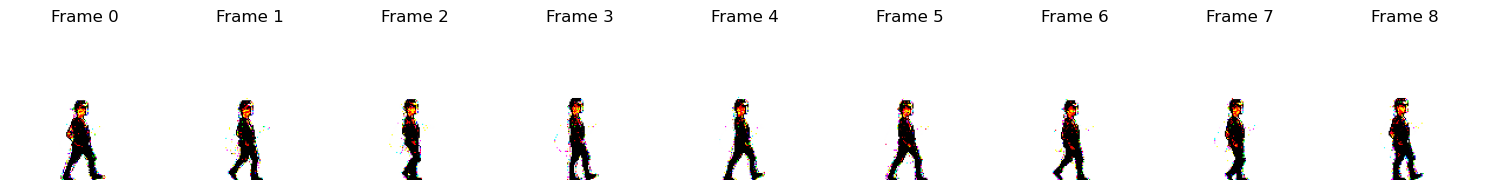

In [8]:
import matplotlib.pyplot as plt

def display_predicted_frames(predicted_frames):
    """
    Display predicted frames using Matplotlib.

    Parameters:
    predicted_frames (numpy array): Array of predicted frames.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure to display the frames
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)  # Create a subplot for each frame
        plt.imshow(predicted_frames[i])  # Display the frame
        plt.axis('off')  # Hide the axes
        plt.title(f'Frame {i}')  # Optional: add title to each frame

    plt.tight_layout()  # Adjust subplots to fit in to the figure area.
    plt.show()  # Show the plot

# Example usage after prediction
display_predicted_frames(predicted_frames)